<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#PyMc-context" data-toc-modified-id="PyMc-context-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PyMc context</a></span></li><li><span><a href="#PyMC-Variables" data-toc-modified-id="PyMC-Variables-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PyMC Variables</a></span></li><li><span><a href="#Stochastics-vs.-deterministic-variables" data-toc-modified-id="Stochastics-vs.-deterministic-variables-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Stochastics vs. deterministic variables</a></span></li><li><span><a href="#Initializing-Stochastic-variables" data-toc-modified-id="Initializing-Stochastic-variables-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Initializing Stochastic variables</a></span></li><li><span><a href="#Deterministic-variables" data-toc-modified-id="Deterministic-variables-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Deterministic variables</a></span></li><li><span><a href="#Theano" data-toc-modified-id="Theano-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Theano</a></span></li><li><span><a href="#Including-observations-in-the-model" data-toc-modified-id="Including-observations-in-the-model-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Including observations in the model</a></span></li><li><span><a href="#References" data-toc-modified-id="References-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Requirements" data-toc-modified-id="Requirements-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Requirements</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** PyMC variables

</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import pymc3 as pm
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

# PyMc context
<hr style = "border:2px solid black" ></hr>

- In PyMC3, we typically handle all the variables we want in our model within the context of the `Model` object.

In [2]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

This is an extra layer of convenience compared to PyMC. Any variables created within a given `Model`'s context will be automatically assigned to that model. If you try to define a variable outside of the context of a model, you will get an error.

We can continue to work within the context of the same model by using `with` with the name of the model object that we have already created.

In [3]:
with model:
    data_plus_one = data_generator + 1

We can examine the same variables outside of the model context once they have been defined, but to define more variables that the model will recognize they have to be within the context.

In [4]:
parameter.tag.test_value

array(0.69314718)

Each variable assigned to a model will be defined with its own name, the first string parameter (we will cover this further in the variables section). To create a different model object with the same name as one we have used previously, we need only run the first block of code again.

In [5]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

We can also define an entirely separate model. Note that we are free to name our models whatever we like, so if we do not want to overwrite an old model we need only make another.

In [6]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

You probably noticed that PyMC3 will often give you notifications about transformations when you add variables to your model. These transformations are done internally by PyMC3 to modify the space that the variable is sampled in (when we get to actually sampling the model). This is an internal feature which helps with the convergence of our samples to the posterior distribution and serves to improve the results.

# PyMC Variables
<hr style = "border:2px solid black" ></hr>

- All PyMC3 variables have an initial value (i.e. test value). Using the same variables from before:

In [7]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


The `test_value` is used only for the model, as the starting point for sampling if no other start is specified. It will not change as a result of sampling. This initial state can be changed at variable creation by specifying a value for the `testval` parameter.

In [8]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)


parameter.tag.test_value = 0.5


# Stochastics vs. deterministic variables
<hr style = "border:2px solid black" ></hr>

- PyMC3 is concerned with two types of programming variables: stochastic and deterministic.

    - * *stochastic variables** are variables that are not deterministic, i.e., even if you knew all the values of the variables' parameters and components, it would still be random. Included in this category are instances of classes `Poisson`, `DiscreteUniform`, and `Exponential`.

    - **deterministic variables** are variables that are not random if the variables' parameters and components were known. 

# Initializing Stochastic variables
<hr style = "border:2px solid black" ></hr>



Initializing a stochastic, or random, variable requires a `name` argument, plus additional parameters that are class specific. For example:

`some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)`

where 0, 4 are the `DiscreteUniform`-specific lower and upper bound on the random variable. The [PyMC3 docs](https://docs.pymc.io/en/stable/api.html) contain the specific parameters for stochastic variables. (Or use `??` if you are using IPython!)

The `name` attribute is used to retrieve the posterior distribution later in the analysis, so it is best to use a descriptive name. Typically, I use the Python variable's name as the `name`.

For multivariable problems, rather than creating a Python array of stochastic variables, addressing the `shape` keyword in the call to a stochastic variable creates multivariate array of (independent) stochastic variables. The array behaves like a NumPy array when used like one, and references to its `tag.test_value` attribute return NumPy arrays.  

The `shape` argument also solves the annoying case where you may have many variables $\beta_i, \; i = 1,...,N$ you wish to model. Instead of creating arbitrary names and variables for each one, like:

    beta_1 = pm.Uniform("beta_1", 0, 1)
    beta_2 = pm.Uniform("beta_2", 0, 1)
    ...

we can instead wrap them into a single variable:

    betas = pm.Uniform("betas", 0, 1, shape=N)

# Deterministic variables
<hr style = "border:2px solid black" ></hr>

We can create a deterministic variable similarly to how we create a stochastic variable. We simply call up the `Deterministic` class in PyMC3 and pass in the function that we desire

    deterministic_variable = pm.Deterministic("deterministic variable", some_function_of_variables)

For all purposes, we can treat the object `some_deterministic_var` as a variable and not a Python function. 

Calling `pymc3.Deterministic` is the most obvious way, but not the only way, to create deterministic variables. Elementary operations, like addition, exponentials etc. implicitly create deterministic variables. For example, the following returns a deterministic variable:

In [9]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

If we want a `deterministic` variable to actually be tracked by our sampling, however, we need to define it explicitly as a named `deterministic` variable with the constructor.

The use of the `deterministic` variable was seen in the previous chapter's text-message example.  Recall the model for $\lambda$ looked like: 

$$
\lambda = 
\begin{cases}\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

And in PyMC3 code:

In [10]:
import numpy as np

n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

Clearly, if $\tau, \lambda_1$ and $\lambda_2$ are known, then $\lambda$ is known completely, hence it is a deterministic variable. We use the `switch` function here to change from $\lambda_1$ to $\lambda_2$ at the appropriate time. This function is directly from the `theano` package, which we will discuss in the next section.

Inside a `deterministic` variable, the stochastic variables passed in behave like scalars or NumPy arrays (if multivariable). We can do whatever we want with them as long as the dimensions match up in our calculations.

For example, running the following:

    def subtract(x, y):
        return x - y
    
    stochastic_1 = pm.Uniform("U_1", 0, 1)
    stochastic_2 = pm.Uniform("U_2", 0, 1)
    
    det_1 = pm.Deterministic("Delta", subtract(stochastic_1, stochastic_2))
    
Is perfectly valid PyMC3 code. Saying that our expressions behave like NumPy arrays is not exactly honest here, however. The main catch is that the expression that we are making *must* be compatible with `theano` tensors, which we will cover in the next section. Feel free to define whatever functions that you need in order to compose your model. However, if you need to do any array-like calculations that would require NumPy functions, make sure you use their equivalents in `theano`.

# Theano
<hr style = "border:2px solid black" ></hr>

The majority of the heavy lifting done by PyMC3 is taken care of with the `theano` package. The notation in `theano` is remarkably similar to NumPy. It also supports many of the familiar computational elements of NumPy. However, while NumPy directly executes computations, e.g. when you run `a + b`, `theano` instead builds up a "compute graph" that tracks that you want to perform the `+` operation on the elements `a` and `b`. Only when you `eval()` a `theano` expression does the computation take place (i.e. `theano` is lazy evaluated). Once the compute graph is built, we can perform all kinds of mathematical optimizations (e.g. simplifications), compute gradients via autodiff, compile the entire graph to C to run at machine speed, and also compile it to run on the GPU. PyMC3 is basically a collection of `theano` symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients. For practical purposes, what this means is that in order to build certain models we sometimes have to use `theano`.

Let's write some PyMC3 code that involves `theano` calculations.

In [11]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

- Here we use `theano`'s `stack()` function in the same way we would use one of NumPy's stacking functions: to combine our two separate variables, `p1` and `p2`, into a vector with $2$ elements. 
- The stochastic `categorical` variable does not understand what we mean if we pass a NumPy array of `p1` and `p2` to it because they are both `theano` variables. Stacking them like this combines them into one `theano` variable that we can use as the complementary pair of probabilities for our two categories.

# Including observations in the model
<hr style = "border:2px solid black" ></hr>

- At this point, it may not look like it, but we have fully specified our priors. 
- For example, we can ask and answer questions like "What does my prior distribution of $\lambda_1$ look like?" 

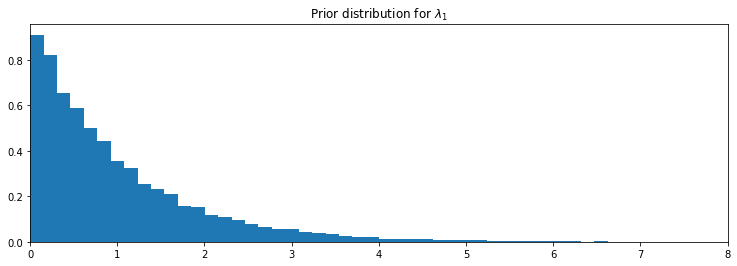

In [12]:
figsize(12.5, 4)


samples = lambda_1.random(size=20000)
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8)

To frame this in the notation of the first chapter, though this is a slight abuse of notation, we have specified $P(A)$. Our next goal is to include data/evidence/observations $X$ into our model. 

PyMC3 stochastic variables have a keyword argument `observed`. The keyword `observed` has a very simple role: fix the variable's current value to be the given data, typically a NumPy `array` or pandas `DataFrame`. For example:

In [13]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


This is how we include data into our models: initializing a stochastic variable to have a *fixed value*. 

To complete our text message example, we fix the PyMC3 variable `observations` to the observed dataset. 

In [14]:
# We're using some fake data here
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb
- Davidson-Pilon, Cameron. Bayesian methods for hackers: probabilistic programming and Bayesian inference. Addison-Wesley Professional, 2015.

</font>
</div>

# Requirements
<hr style = "border:2px solid black" ></hr>

In [15]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

numpy     : 1.21.6
json      : 2.0.9
pymc3     : 3.11.5
scipy     : 1.7.3
autopep8  : 1.7.0
theano    : 1.1.2
matplotlib: 3.5.3

